In [68]:
from utils import *
import pandas as pd
import pickle
import networkx as nx

connected_time = 0
global it, level
it = 0
level = 0

def k_conn_avg_deg_aux(G, H, k, verbose=False):
#     global connected_time, it, level
    if verbose:
#         global it, level
        it = it + 1
        level = level + 1
        print('  ' * level, "iteration =", it, "level =", level, "nodes =", len(G.nodes()), len(H.nodes()))    
        print('  ' * level, "Computing %i-connected components..." % k,)
        
    start_time = time.time()
    comps = k_connected_components(G, k)
    connected_time += (time.time()-start_time)
    if verbose: print("done")
    
    if comps == []:                 
        # No k-connected component: no solution
        return []                      
    elif len(comps) > 1 or len(comps[0]) != G.number_of_nodes():                   
        # G is not k-connected
        subgraphs = ( k_conn_min_deg_aux(G.subgraph(c), H.subgraph(c), k, verbose=verbose) for c in comps )    
    else:                                   
        # G is k-connected
        # Remove the lowest core. This is better than just removing the lowest-degree vertex as it
        # avoids many useless computations of k-conected components
        cn = nx.core_number(G)
        deg = min(cn.values())        
        others = [ v for (v, i) in cn.iteritems() if i > deg ]
        
        subgraphs = ( H.nodes(), k_conn_min_deg_aux(G.subgraph(others), H.subgraph(others), k, verbose=verbose) )
        
    if verbose: level = level - 1
    
    # Return the best (highest min-degree) solution among those in subgraphs. Break ties by density.
    return max(subgraphs, key=lambda S: (min_deg(H.subgraph(S)), density(H.subgraph(S))) )                
        
def k_conn_avg_deg(G, H, k, verbose=False):    
    if verbose:
        global it, level
        it, level = 0, 0
    S = k_conn_avg_deg_aux(G, H.copy(), k, verbose=verbose)
    GS, HS, avgdeg = G.subgraph(S), H.subgraph(S), density(H.subgraph(S))
    assert GS.nodes() == HS.nodes()
    if verbose: print "size(S) =", len(S)
    assert S == [] or is_k_connected(G.subgraph(S), k)
    return S, avgdeg

def get_key(my_dict, vals):
    result = []
    for key, value in my_dict.items():
        if value in vals:
            result.append(key)
    if len(result) != len(vals):
        print('some vals not in dict')
        return []
    return result

def plot_S(node_map, S, G1, G2, save_path, plot=True, fig_size=(10,10), node_size=30, with_labels=False, width=0.2):
    if len(node_map)!=0:
        original_S = get_key(node_map, S)
    else:
        original_S = S
    g = G1.subgraph(original_S)
    h = G2.subgraph(original_S)
    h_deg = [deg for node,deg in h.degree()]
    if plot:
        fig, axes = plt.subplots(figsize=fig_size, nrows=1, ncols=1)
        nx.draw_networkx(g, ax=axes, with_labels=with_labels, node_size=node_size, width=width)
        axes.set_axis_off()
        plt.savefig(save_path + '_connect.png')
        plt.show()

        fig, axes = plt.subplots(figsize=fig_size, nrows=1, ncols=1)
        nx.draw_networkx(h, ax=axes, with_labels=with_labels, node_size=node_size, width=width)
        axes.set_axis_off()

        plt.savefig(save_path + '_dense.png')
        plt.show()
    
    k = 1
    while is_k_connected(h, k):
        k += 1
    try:
        print('min deg \t average deg \t max deg \t triangle \t k-connectivity')
        print(min(h_deg), np.average(h_deg), max(h_deg), sum(nx.triangles(h).values())/3, k-1)
    except nx.NetworkXError:
        print('subgraph of H not connected')
#     return g, h

In [17]:
node_map = {}
cur_node_ind = 0

In [18]:
def read_graph(gt, node_map, node_index, start_date=1, end_date=28, weighted=False):
    g = nx.Graph()
#     node_mapping = {}
    path_pre = '../../anomaly_data/twitter_mancer/dataset/'

#     graph_types = ["quote", "reply", "retweet"]
    filenames = [gt+"-2018-02-"+str(i).zfill(2)+".txt" for i in xrange(int(start_date), int(end_date)+1)]
    for filename in filenames:
        t = 0
        with open(path_pre+filename, 'r') as f:
            for edge in f:
                nodes = edge.split()
                u = nodes[0]
                v = nodes[1]
                if (u == "deleted") or (v == "deleted"):
                    pass
                elif ( u == v ):
                    pass
                else:
                    if u not in node_map:
                        node_map[u] = node_index
                        node_index += 1
                    if v not in node_map:
                        node_map[v] = node_index
                        node_index += 1
                    if weighted:
                        if g.has_edge(node_map[u],node_map[v]):
                            g[node_map[u]][node_map[v]]['weight'] += 1
                        else:
                            g.add_edge(node_map[u],node_map[v], weight=1)
                    else:
                        g.add_edge(node_map[u],node_map[v])
    return g, node_index

In [19]:
replyG, cur_node_ind = read_graph('reply', node_map, cur_node_ind)
quoteG, cur_node_ind = read_graph('quote', node_map, cur_node_ind)

In [20]:
common = (set(replyG.nodes) & set(quoteG.nodes))

print '# of common nodes in retweet and quote', len(common)
print '# of edges in the reply subgraph induced by common nodes', len(replyG.subgraph(common).edges)
print '# of edges in the quote subgraph induced by common nodes', len(quoteG.subgraph(common).edges)    


# of common nodes in retweet and quote 153581
# of edges in the reply subgraph induced by common nodes 460149
# of edges in the quote subgraph induced by common nodes 479474


In [24]:
reply_quote_S = []
ts = []
global connected_time
for k in [5, 20, 35, 50]:
    connected_time = 0
    s_time = time.time()
    S, avgdeg = k_conn_avg_deg(replyG.subgraph(common), quoteG.subgraph(common), k, verbose=False)
    run_t = time.time()-s_time
    print(run_t, connected_time)
    ts.append((run_t, connected_time))
    print 'size of dense-connected subgraph', len(S)
    print '# of edges in the k-connected reply subgraph', len(replyG.subgraph(S).edges)
    print '# of edges in the dense quote subgraph', len(quoteG.subgraph(S).edges) 
    if avgdeg==0:
        print 'subgraph h not connected.'
        break
#     plot_S(dict(), S, replyG, quoteG, fig_prefix + 'reply_quote_k=' + str(k), plot=False)
    
    
    reply_quote_S.append(S)


(369.1223599910736, 1.4656221866607666)
size of dense-connected subgraph 395
# of edges in the k-connected reply subgraph 8709
# of edges in the dense quote subgraph 26954
(738.5645899772644, 19.984143018722534)
size of dense-connected subgraph 325
# of edges in the k-connected reply subgraph 8863
# of edges in the dense quote subgraph 16788
(410.5267539024353, 13.463351011276245)
size of dense-connected subgraph 271
# of edges in the k-connected reply subgraph 8309
# of edges in the dense quote subgraph 11126
(42.87538003921509, 7.5374839305877686)
size of dense-connected subgraph 334
# of edges in the k-connected reply subgraph 13157
# of edges in the dense quote subgraph 11498


In [25]:
ts

[(369.1223599910736, 1.4656221866607666),
 (738.5645899772644, 19.984143018722534),
 (410.5267539024353, 13.463351011276245),
 (42.87538003921509, 7.5374839305877686)]

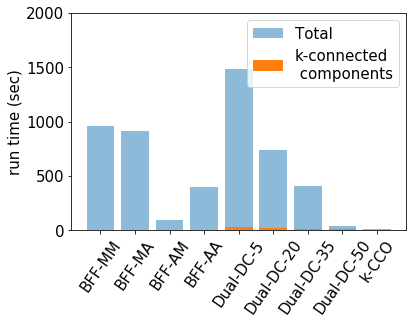

In [73]:
plt.rcParams.update({'font.size': 15})

# Running time of BFF variants are reported in their java output files.

times = [959.2, 912.3, 98, 401.8, 1486.9, 738, 410, 42, 14]
conn_time = [32.6, 20, 13.5, 7.5]

labels = ['BFF-MM', 'BFF-MA', 'BFF-AM', 'BFF-AA', 'Dual-DC-5', 'Dual-DC-20', 'Dual-DC-35', 'Dual-DC-50', 'k-CCO']
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
ax.bar(x_pos, times,
       align='center',
       alpha=0.5,
       capsize=10, label='Total')
ax.bar([i for i in range(4,8)], conn_time,
       align='center',
       alpha=1,
       capsize=10, label='k-connected\n components')
ax.set_ylabel('run time (sec)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=55)
ax.set_ylim([0, 2000])
# plt.yscale('log')

# Save the figure and show
plt.legend()
# plt.tight_layout()
# plt.savefig('run_time_twitter.png')
plt.show()

In [70]:
reply_quote_S = []
it = 0
level = 0
for k in [5]:

    connected_time = 0
    s_time = time.time()
    S, avgdeg = k_conn_min_deg(replyG.subgraph(common), quoteG.subgraph(common), k, verbose=True)
    run_t = time.time()-s_time
    print(run_t, connected_time)
    ts.append((run_t, connected_time))
    print 'size of dense-connected subgraph', len(S)
    print '# of edges in the k-connected reply subgraph', len(replyG.subgraph(S).edges)
    print '# of edges in the dense quote subgraph', len(quoteG.subgraph(S).edges) 
    if avgdeg==0:
        print 'subgraph h not connected.'
        break
#     plot_S(dict(), S, replyG, quoteG, fig_prefix + 'reply_quote_k=' + str(k), plot=False)
    
    
    reply_quote_S.append(S)


   iteration = 1 level = 1 nodes = 153581 153581
   Computing 5-connected components...
     iteration = 2 level = 2 nodes = 141963 141963
     Computing 5-connected components...
done
     iteration = 3 level = 2 nodes = 25 25
     Computing 5-connected components...
done
     connected component found 25 1 1 20 3
       iteration = 4 level = 3 nodes = 20 20
       Computing 5-connected components...
done
       connected component found 20 2 2 14 3
         iteration = 5 level = 4 nodes = 14 14
         Computing 5-connected components...
done
         iteration = 6 level = 4 nodes = 12 12
         Computing 5-connected components...
           iteration = 7 level = 5 nodes = 11 11
           Computing 5-connected components...
done
           connected component found 11 3 3 0 3
             iteration = 8 level = 6 nodes = 0 0
             Computing 5-connected components...
       iteration = 9 level = 3 nodes = 19135 19135
       Computing 5-connected components...
         iterat

                                                         iteration = 57 level = 28 nodes = 7793 7793
                                                         Computing 5-connected components...
done
                                                         connected component found 7793 6 6 7201 84
                                                           iteration = 58 level = 29 nodes = 7201 7201
                                                           Computing 5-connected components...
done
                                                           iteration = 59 level = 29 nodes = 7080 7080
                                                           Computing 5-connected components...
                                                             iteration = 60 level = 30 nodes = 7041 7041
                                                             Computing 5-connected components...
done
                                                             iteration = 61 level = 30 nodes 

done
                                                                                             iteration = 91 level = 46 nodes = 5463 5463
                                                                                             Computing 5-connected components...
done
                                                                                             connected component found 5463 10 10 5184 84
                                                                                               iteration = 92 level = 47 nodes = 5184 5184
                                                                                               Computing 5-connected components...
done
                                                                                               iteration = 93 level = 47 nodes = 5142 5142
                                                                                               Computing 5-connected components...
                                         

done
                                                                                                                         iteration = 117 level = 60 nodes = 4119 4119
                                                                                                                         Computing 5-connected components...
                                                                                                                           iteration = 118 level = 61 nodes = 4112 4112
                                                                                                                           Computing 5-connected components...
done
                                                                                                                           iteration = 119 level = 61 nodes = 4109 4109
                                                                                                                           Computing 5-connected components...
             

done
                                                                                                                                                   iteration = 139 level = 73 nodes = 3364 3364
                                                                                                                                                   Computing 5-connected components...
                                                                                                                                                     iteration = 140 level = 74 nodes = 3355 3355
                                                                                                                                                     Computing 5-connected components...
done
                                                                                                                                                     iteration = 141 level = 74 nodes = 3354 3354
                                          

done
                                                                                                                                                                         iteration = 158 level = 84 nodes = 2701 2701
                                                                                                                                                                         Computing 5-connected components...
                                                                                                                                                                           iteration = 159 level = 85 nodes = 2699 2699
                                                                                                                                                                           Computing 5-connected components...
done
                                                                                                                                                    

done
                                                                                                                                                                                           connected component found 2198 28 28 2130 84
                                                                                                                                                                                             iteration = 174 level = 94 nodes = 2130 2130
                                                                                                                                                                                             Computing 5-connected components...
done
                                                                                                                                                                                             iteration = 175 level = 94 nodes = 2125 2125
                                                                 

done
                                                                                                                                                                                                               iteration = 189 level = 103 nodes = 1777 1777
                                                                                                                                                                                                               Computing 5-connected components...
done
                                                                                                                                                                                                               connected component found 1777 35 35 1703 84
                                                                                                                                                                                                                 iteration = 190 level = 104 nodes

done
                                                                                                                                                                                                                               iteration = 203 level = 111 nodes = 1350 1350
                                                                                                                                                                                                                               Computing 5-connected components...
                                                                                                                                                                                                                                 iteration = 204 level = 112 nodes = 1349 1349
                                                                                                                                                                                                    

done
                                                                                                                                                                                                                                                 iteration = 216 level = 120 nodes = 1180 1180
                                                                                                                                                                                                                                                 Computing 5-connected components...
                                                                                                                                                                                                                                                   iteration = 217 level = 121 nodes = 1179 1179
                                                                                                                                              

                                                                                                                                                                                                                                                                   iteration = 229 level = 129 nodes = 1058 1058
                                                                                                                                                                                                                                                                   Computing 5-connected components...
done
                                                                                                                                                                                                                                                                   connected component found 1058 50 50 1030 84
                                                                                           

done
                                                                                                                                                                                                                                                                                 connected component found 920 55 55 904 83
                                                                                                                                                                                                                                                                                   iteration = 241 level = 137 nodes = 904 904
                                                                                                                                                                                                                                                                                   Computing 5-connected components...
done
                                            

done
                                                                                                                                                                                                                                                                                               connected component found 803 59 59 779 83
                                                                                                                                                                                                                                                                                                 iteration = 252 level = 144 nodes = 779 779
                                                                                                                                                                                                                                                                                                 Computing 5-connected components...
done
  

done
                                                                                                                                                                                                                                                                                                             connected component found 674 65 65 658 83
                                                                                                                                                                                                                                                                                                               iteration = 262 level = 151 nodes = 658 658
                                                                                                                                                                                                                                                                                                               C

done
                                                                                                                                                                                                                                                                                                                           connected component found 586 69 69 572 82
                                                                                                                                                                                                                                                                                                                             iteration = 272 level = 158 nodes = 572 572
                                                                                                                                                                                                                                                                                    

done
                                                                                                                                                                                                                                                                                                                                           iteration = 281 level = 165 nodes = 438 438
                                                                                                                                                                                                                                                                                                                                           Computing 5-connected components...
                                                                                                                                                                                                                                                             

done
                                                                                                                                                                                                                                                                                                                                                         iteration = 291 level = 172 nodes = 346 346
                                                                                                                                                                                                                                                                                                                                                         Computing 5-connected components...
                                                                                                                                                                                                                                 

AttributeError: 'str' object has no attribute 'append'

In [72]:
S, avgdeg = k_conn_min_deg(replyG.subgraph(common), quoteG.subgraph(common), 50, verbose=True)

   iteration = 1 level = 1 nodes = 153581 153581
   Computing 50-connected components...
     iteration = 2 level = 2 nodes = 141963 141963
     Computing 50-connected components...
done
     iteration = 3 level = 2 nodes = 889 889
     Computing 50-connected components...
       iteration = 4 level = 3 nodes = 881 881
       Computing 50-connected components...
done
       iteration = 5 level = 3 nodes = 867 867
       Computing 50-connected components...
done
       connected component found 867 1 1 855 65
         iteration = 6 level = 4 nodes = 855 855
         Computing 50-connected components...
done
         iteration = 7 level = 4 nodes = 845 845
         Computing 50-connected components...
done
         connected component found 845 2 2 837 64
           iteration = 8 level = 5 nodes = 837 837
           Computing 50-connected components...
done
           iteration = 9 level = 5 nodes = 788 788
           Computing 50-connected components...
done
           connected compone

In [ ]:

s_time = time.time()
r = kcco(replyG.subgraph(common), quoteG.subgraph(common), 5)
print 'final', r.number_of_nodes()
run_t = time.time()-s_time
run_t

In [61]:
k = 1
while is_k_connected(replyG.subgraph(r[0]), k):
    k += 1
print k-1

 1


In [63]:
nx.is_connected(replyG.subgraph(r[0]))

True